# Sound Classification In hospital Using DCNN
This code will train 
## 1. Load necessary Library

In [5]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import csv
import io
import librosa
import IPython
import pickle
import os
import json
from paramiko import SSHClient
import h5py
from scp import SCPClient
import scipy.signal as sg
import matplotlib.pyplot as plt
import matplotlib.patches as pt
import seaborn as sns
from urllib.parse import unquote
# from scipy.ndimage.filters import gaussian_filter1d
import keras
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, plot_model
from tqdm import tqdm
from urllib.parse import unquote
from object_lib import *
import shutil

## 2. Preparation

Load in label data from label studio

In [6]:
with open('dataset/labels.csv', 'r') as f:
    db = pd.read_csv(f)

In [17]:
client = SSHClient()
client.load_system_host_keys()
client.connect('192.168.1.109', username='worker')
scp = SCPClient(client.get_transport())
folder = os.listdir()
for loc in tqdm(db.audio, total=len(db.audio)):
    fname = unquote(loc.split('/')[-1])
    if fname not in folder:
        scp.get('/home/worker/.local/share/label-studio/media/upload/1/'+fname, os.path.join(os.getcwd(), 'dataset'))

100%|██████████| 68/68 [00:17<00:00,  3.78it/s]


In [7]:
sc = soundClassifier()
sc.prepareData("dataset/labels.csv")
df = pd.DataFrame.from_dict(sc.training_data)
dataset =pd.DataFrame.from_dict(sc.training_data).to_dict(orient="list")
print(len(df))
df.head()

2024-07-22 17:50:59.066950: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 118751232 exceeds 10% of free system memory.


954


,audio_name,x,y,map,length_x,yamresult,fold,embeddings
0,e01cb396-Mcu_done_infusion-error.m4a,"[0.004008347, 0.006536768, 0.0075709643, 0.006...",ICU Medical,0,18497,"[[Beep, bleep, 0.46209908]]",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17176944..."
1,e01cb396-Mcu_done_infusion-error.m4a,"[-0.00274926, -0.0031339775, -0.0060511483, -0...",ICU Medical,0,17637,"[[Wind chime, 0.30114472], [Chime, 0.36129132]...",0,"[0.0, 0.0, 0.03382997, 0.4453789, 0.0, 0.0, 0...."
2,e01cb396-Mcu_done_infusion-error.m4a,"[-0.004658336, -0.0056570256, -0.0048019295, -...",ICU Medical,0,18067,"[[Beep, bleep, 0.439968]]",0,"[0.0, 0.0, 0.0, 0.35128084, 0.0, 0.0, 0.0, 0.3..."
3,e01cb396-Mcu_done_infusion-error.m4a,"[0.004154419, 0.0038092355, 0.0012775509, 0.00...",ICU Medical,0,18497,"[[Beep, bleep, 0.6084529]]",0,"[0.0, 0.0020275738, 0.013133825, 0.044355366, ..."
4,e01cb396-Mcu_done_infusion-error.m4a,"[-0.00013345154, -0.0028335587, -0.0056317346,...",ICU Medical,0,19358,"[[Beep, bleep, 0.5904304]]",0,"[0.0, 0.0, 0.048816357, 0.43711212, 0.0, 0.0, ..."


In [9]:
def load_model_ext(filepath, custom_objects=None):
    model = tf.keras.models.load_model(filepath, custom_objects=None)
    f = h5py.File(filepath, mode='r')
    meta_data = None
    if 'label_data' in f.attrs:
        meta_data = f.attrs.get('label_data')
    f.close()
    return model, meta_data
   

def save_model_ext(model, filepath, overwrite=True, meta_data=None):
    tf.keras.models.save_model(model, filepath, overwrite)
    if meta_data is not None:
        f = h5py.File(filepath, mode='a')
        f.attrs['label_data'] = meta_data
        f.close()
        
def load_data(df):
    waveforms = df.x.to_numpy()
    labels = df.map.to_numpy()
    features = []
    labelset = []

    for index, (audio, label) in tqdm(enumerate(zip(waveforms, labels)), total=len(waveforms)):
        # Load the audio file and resample it
        sample_rate = 16000
        for i in range(int(np.floor(len(audio)/(0.45*sample_rate)))+1):
            start = int(i*(0.45*sample_rate))
            end = int(start+(0.92*sample_rate))
            audio_94 = audio[start:end]
            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=audio_94, sr=sample_rate, n_mfcc=40)
            mfccs_scaled = np.mean(mfccs.T, axis=0)
            # Append features and labels
            features.append(mfccs_scaled)
            labelset.append(label)
    return np.array(features), np.array(labelset)
data, labelset= load_data(df)
print(f"Data loaded with {len(data)} data points")

100%|██████████| 954/954 [00:12<00:00, 73.54it/s] 

Data loaded with 3657 data points


In [6]:
# labels_onehot = [tf.stack for a in to_categorical(df['map'])]
labels_onehot = np.array(to_categorical(labelset))
X_train, X_test, y_train, y_test = train_test_split(data, labels_onehot, test_size=0.2, random_state=42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

2925 2925 732 732


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 40, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,136 (1.47 MB)

 Trainable params: 386,136 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

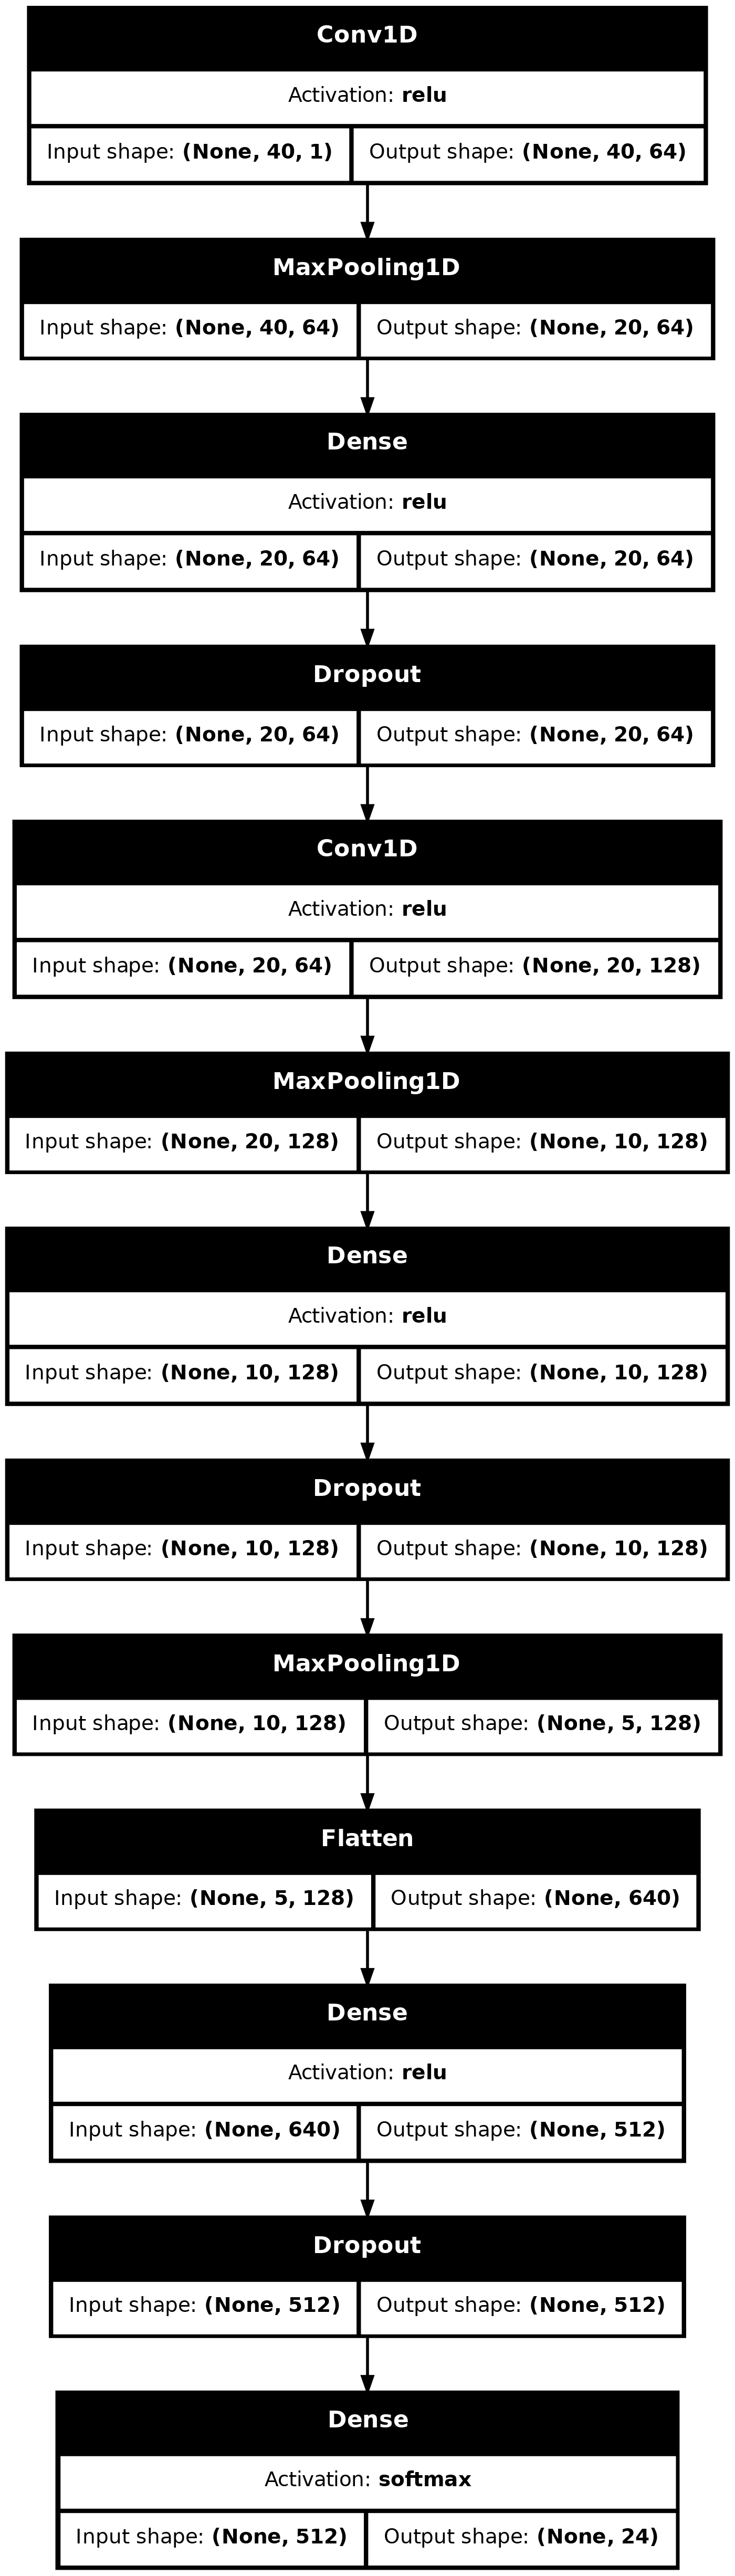

In [8]:
input_shape = (X_train.shape[1], 1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=input_shape))
model.add(tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(len(y_train[0]), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
plot_model(model, to_file="wfmodel.png", show_shapes=True, show_layer_activations=True)

Epoch 1/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8136 - loss: 0.6575 - val_accuracy: 0.8511 - val_loss: 0.5826
Epoch 2/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8560 - loss: 0.4339 - val_accuracy: 0.8716 - val_loss: 0.5096
Epoch 3/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8686 - loss: 0.4214 - val_accuracy: 0.8648 - val_loss: 0.5732
Epoch 4/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8660 - loss: 0.4099 - val_accuracy: 0.8743 - val_loss: 0.5233
Epoch 5/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8786 - loss: 0.3636 - val_accuracy: 0.8607 - val_loss: 0.5424
Epoch 6/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8947 - loss: 0.3752 - val_accuracy: 0.8607 - val_loss: 0.5044
Epoch 7/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8992 - loss: 0.3010 - val_accuracy: 0.8757 - val_loss: 0.5040
Epoch 8/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8891 - loss: 0.3343 - val_accu

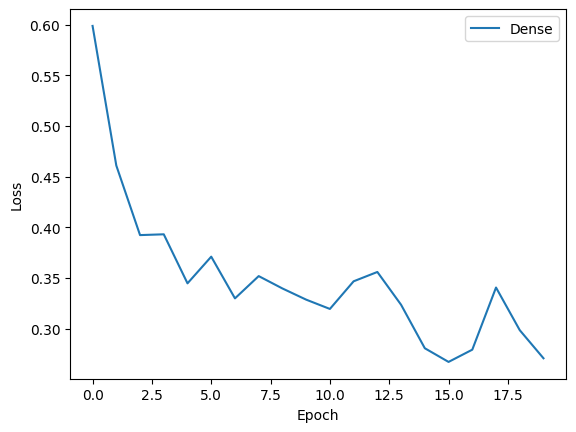

In [12]:
# callback = EarlyStopping(patience=10, monitor='val_loss')
callback = EarlyStopping(patience=4, min_delta=1e-3, monitor='accuracy')
history1 = model.fit(X_train, 
          y_train, 
          batch_size=8,
          epochs=100, 
          validation_data=(X_test, y_test), 
          verbose=1, 
          callbacks=[callback,]
        )
# fig=plt.figure(figsize=(12,4))
plt.plot(history1.epoch, history1.history['loss'], label="Dense")
# plt.plot(history1.epoch, history1.history['accuracy'], label="Dense")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [10]:
# Model Saved
model = tf.keras.models.load_model('trained_model.h5')
save_model_ext(model, 'trained_model.h5', meta_data=sc.labelBucket )
model.save_weights('trained_model.weights.h5')

In [3]:
shutil.copy2('trained_model.weights.h5', '../soundClassifier_client/')
shutil.copy2('trained_model.h5', '../soundClassifier_client/')

'../soundClassifier_client/trained_model.h5'